# Neural Networks
(core)

*Christina Brockway*

Data Source: Kaggle
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=sample_submission.csv

## Required Task:  
**Build a neural network using this data.**1.  
Be sure to perform a train test split on the train.csv so you can evaluate your models
2.  
Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance. Be sure to include some form of regularization with at least one mode
3.  .
Select your best model!

### Load Data and Imorts

In [1]:
# Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

#Evaluation tools
from sklearn.metrics import mean_absolute_error, r2_score, \
mean_squared_error#, precision_score, recall_score, accuracy_score, f1_score, \
#ConfusionMatrixDisplay, classification_report
from tensorflow import metrics

from sklearn import set_config, config_context
set_config(transform_output='pandas')
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes



def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores


In [3]:
df= pd.read_csv('train.csv', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#dictionary = pd.read_table('data_description.txt')
#dictionary

#### Clean and Explore data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
#Check for duplicate rows
df.duplicated().sum()

0

In [7]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
#check for missing data
missing = df.isna().sum()
percent_missing = ((missing/1460)*100).round(2)
percent_missing

MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
Street            0.00
Alley            93.77
LotShape          0.00
LandContour       0.00
Utilities         0.00
LotConfig         0.00
LandSlope         0.00
Neighborhood      0.00
Condition1        0.00
Condition2        0.00
BldgType          0.00
HouseStyle        0.00
OverallQual       0.00
OverallCond       0.00
YearBuilt         0.00
YearRemodAdd      0.00
RoofStyle         0.00
RoofMatl          0.00
Exterior1st       0.00
Exterior2nd       0.00
MasVnrType        0.55
MasVnrArea        0.55
ExterQual         0.00
ExterCond         0.00
Foundation        0.00
BsmtQual          2.53
BsmtCond          2.53
BsmtExposure      2.60
BsmtFinType1      2.53
BsmtFinSF1        0.00
BsmtFinType2      2.60
BsmtFinSF2        0.00
BsmtUnfSF         0.00
TotalBsmtSF       0.00
Heating           0.00
HeatingQC         0.00
CentralAir        0.00
Electrical        0.07
1stFlrSF          0.00
2ndFlrSF   

**NaN values**  
- After reviewing the Data Dictionary, almost all of the NaN values exist as an "none" value.
- Example:  "PoolQC" is actually none because there is no pool.
- The exception being "Electrical", These rows are actually missing values. Since these rows make up only 0.07% of the data, will drop these rows.
- All other values will be imputed with 0 for numeric features and none for object features during preprocessing

In [9]:
df2= df.dropna(subset=['Electrical'], axis=0)

# Preprocess data for machine learning

In [10]:
# Train Test Split
X= df.drop(columns='SalePrice')
y=df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [11]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1024,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,14.0,Gd,TA,PConc,Gd,Gd,No,GLQ,16,Unf,0,1330,1346,GasA,Ex,Y,SBrkr,1504,0,0,1504,0,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2005.0,Fin,2,437,TA,TA,Y,156,20,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663,LwQ,377,0,1040,GasA,Fa,Y,SBrkr,1309,0,0,1309,1,0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2,484,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1385,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,6,5,1939,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,Mn,Rec,204,Unf,0,356,560,GasA,TA,Y,SBrkr,698,560,0,1258,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1939.0,Unf,1,280,TA,TA,P,0,0,0,0,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal
627,20,RL,NaN,12342,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1960,1978,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,978,978,GasA,TA,Y,SBrkr,1422,0,0,1422,0,0,1,0,3,1,TA,6,Min1,1,TA,Attchd,1960.0,RFn,1,286,TA,TA,Y,0,0,36,0,0,0,NaN,GdWo,Shed,600,8,2007,WD,Normal
814,20,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Gable,CompShg,MetalSd,MetalSd,BrkFace,243.0,TA,TA,CBlock,TA,TA,No,Rec,608,Unf,0,834,1442,GasA,Gd,Y,SBrkr,1442,0,0,1442,0,0,1,1,4,1,TA,7,Typ,0,NaN,Attchd,1958.0,RFn,1,301,TA,TA,Y,0,0,275,0,0,0,NaN,NaN,Shed,500,4,2007,COD,Normal


In [12]:
cat_col= X_train.select_dtypes('object').columns
num_col= X_train.select_dtypes('number').columns

In [13]:
scaler=StandardScaler()
ohe= OneHotEncoder(handle_unknown='ignore', sparse_output=False)
impute= SimpleImputer(strategy='constant', fill_value=0)
oheimpute = SimpleImputer(strategy='constant', fill_value='none')

In [14]:
num_pipe= make_pipeline(impute, scaler)
cat_pipe= make_pipeline(oheimpute, ohe)

In [15]:
num_tuple= ("Numeric", num_pipe, num_col)
cat_tuple=("Catagorical", cat_pipe, cat_col)

preprocessor = ColumnTransformer([num_tuple, cat_tuple], 
                                 remainder='passthrough', sparse_threshold=.5)

In [16]:
preprocessor.fit(X_train)
X_train_tf=preprocessor.transform(X_train)
X_test_tf=preprocessor.transform(X_test)

#### Step 1:  Build Network Structure

In [17]:
# Define network structure

In [18]:
# Save the number of features we have as our input shape
input_shape = X_train_tf.shape[1]
input_shape


300

## Model 1

In [19]:
# Sequential model
model = keras.Sequential()

model.add(Dense(50, input_dim=input_shape, activation ='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation = 'linear'))

#Step 2: compile
model.compile(loss = 'mse', optimizer = 'adam'
              , metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                15050     
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 16,951
Trainable params: 16,951
Non-trainable params: 0
_________________________________________________________________


In [20]:
#Step3: fit model
history = model.fit(X_train_tf, y_train,
                    validation_split = .2, epochs=200, verbose=False)

(<Figure size 600x1200 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'mean_absolute_error'}>,
        <Axes: title={'center': 'root_mean_squared_error'}>], dtype=object))

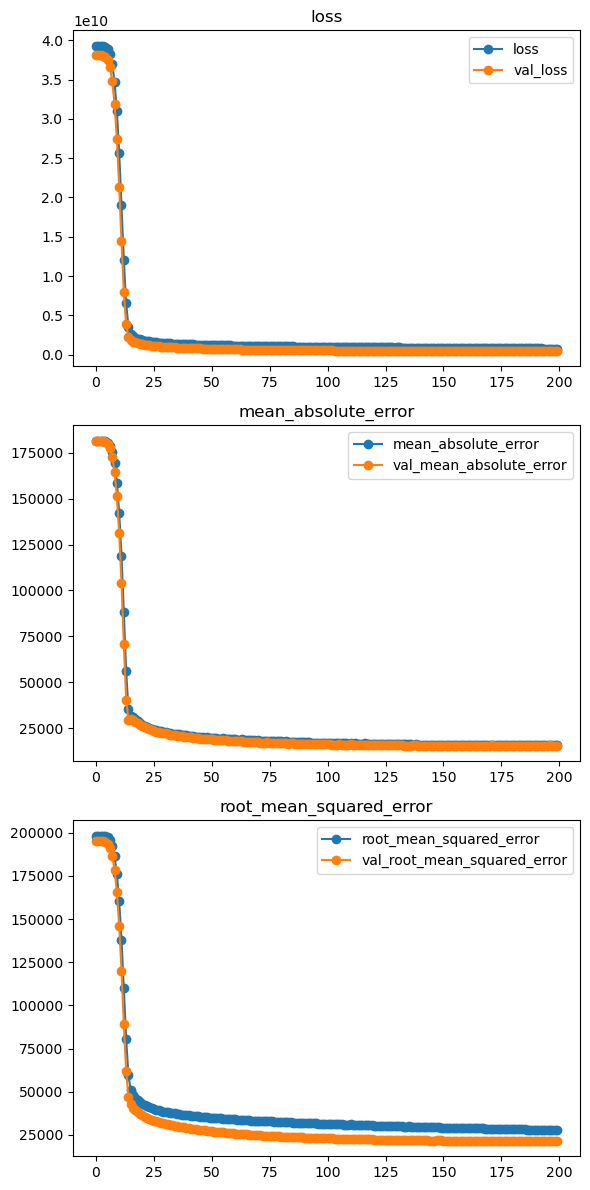

In [21]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history)

In [22]:
# Make predictions and evaluate your model
train_preds = model.predict(X_train_tf)
test_preds = model.predict(X_test_tf)

train_scores = eval_regression(y_train, train_preds, name='Model 1 Train')
test_scores = eval_regression(y_test, test_preds, name='Model 1 Test')

reg_scores = pd.concat([train_scores, test_scores])
reg_scores

12/12 [==============================] - 0s 2ms/step


,RMSE,MAE,R2
Model Name,,,
Model 1 Train,26568.769802,15416.926422,0.883735
Model 1 Test,29256.975856,18295.935691,0.877811


## Model 2

-  Model 1 performeed really well, however it does appear to have leveled off.
-  Adding early stopping as regularization

In [23]:
# Sequential model
model2 = keras.Sequential()

model2.add(Dense(50, input_dim=input_shape, activation ='relu'))
model2.add(Dense(30, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(5, activation='relu'))
model2.add(Dense(1, activation = 'linear'))

#Step 2: compile
model2.compile(loss = 'mse', optimizer = 'adam'
              , metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                15050     
                                                                 
 dense_6 (Dense)             (None, 30)                1530      
                                                                 
 dense_7 (Dense)             (None, 10)                310       
                                                                 
 dense_8 (Dense)             (None, 5)                 55        
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 16,951
Trainable params: 16,951
Non-trainable params: 0
_________________________________________________________________


In [24]:
#Instantiate Early Stopping
early_stopping = EarlyStopping(patience =10)

In [25]:
#Step3: fit model
history2 = model2.fit(X_train_tf, y_train,
                    validation_split = .2, epochs=200, verbose=False)

(<Figure size 600x1200 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'mean_absolute_error'}>,
        <Axes: title={'center': 'root_mean_squared_error'}>], dtype=object))

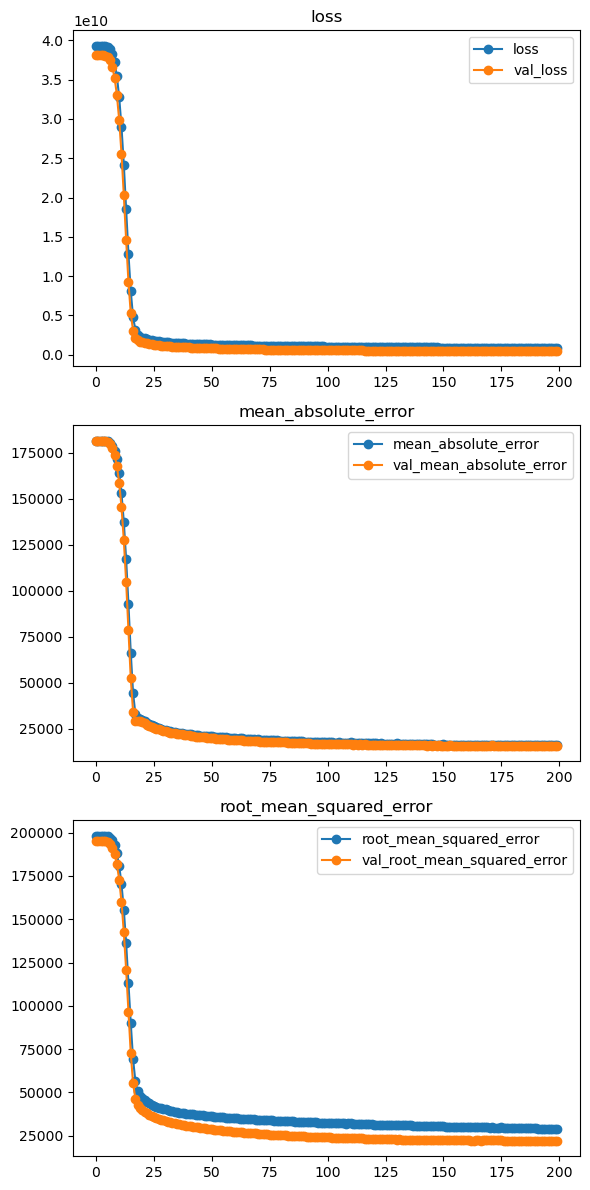

In [26]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history2)

In [27]:
# Make predictions and evaluate your model
train_preds = model2.predict(X_train_tf)
test_preds = model2.predict(X_test_tf)

train_scores = eval_regression(y_train, train_preds, name='Model 2 Train')
test_scores = eval_regression(y_test, test_preds, name='Model 2 Test')

reg_scores = pd.concat([train_scores, test_scores])
reg_scores

12/12 [==============================] - 0s 1ms/step


,RMSE,MAE,R2
Model Name,,,
Model 2 Train,27600.650417,15868.051104,0.874528
Model 2 Test,29786.904513,18528.066931,0.873345


## Model 3

-  Early stopping still could be done earlier, will lower patience

In [33]:
# Sequential model
model3 = keras.Sequential()

model3.add(Dense(50, input_dim=input_shape, activation ='relu'))
model3.add(Dense(30, activation='relu'))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(5, activation='relu'))
model3.add(Dense(1, activation = 'linear'))

#Step 2: compile
model3.compile(loss = 'mse', optimizer = 'adam'
              , metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model3.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                15050     
                                                                 
 dense_16 (Dense)            (None, 30)                1530      
                                                                 
 dense_17 (Dense)            (None, 10)                310       
                                                                 
 dense_18 (Dense)            (None, 5)                 55        
                                                                 
 dense_19 (Dense)            (None, 1)                 6         
                                                                 
Total params: 16,951
Trainable params: 16,951
Non-trainable params: 0
_________________________________________________________________


In [34]:
#Instantiate Early Stopping
early_stopping = EarlyStopping(patience =3)

In [35]:
#Step3: fit model
history3 = model3.fit(X_train_tf, y_train,
                    validation_split = .2, epochs=200, verbose=False)

(<Figure size 600x1200 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'mean_absolute_error'}>,
        <Axes: title={'center': 'root_mean_squared_error'}>], dtype=object))

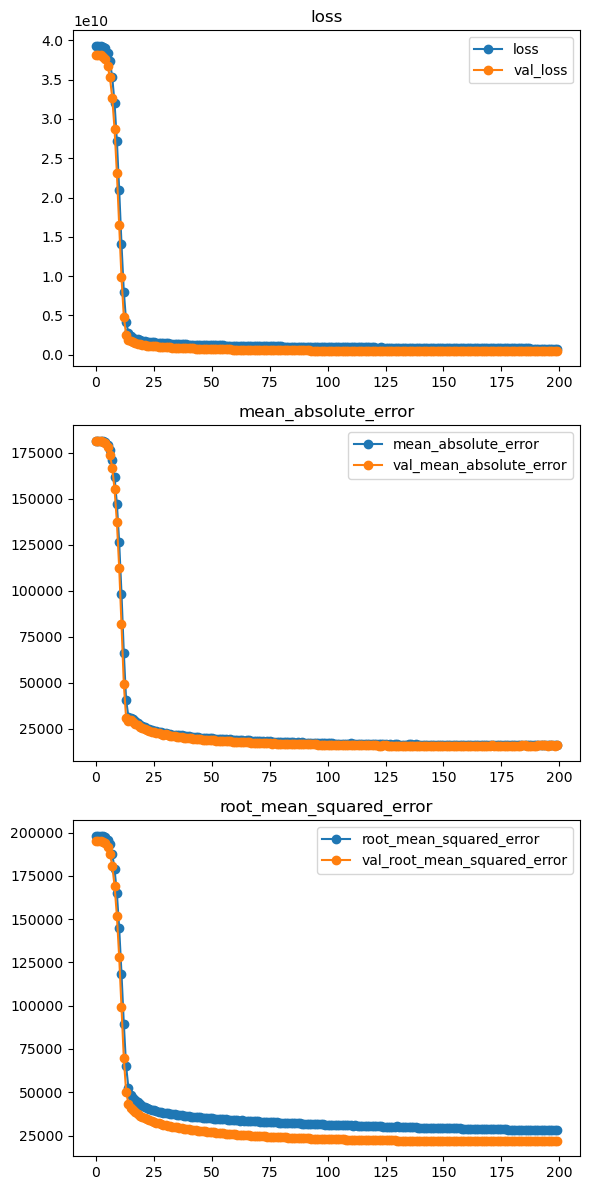

In [36]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history3)

In [37]:
# Make predictions and evaluate your model
train_preds = model3.predict(X_train_tf)
test_preds = model3.predict(X_test_tf)

train_scores = eval_regression(y_train, train_preds, name='Model 3 Train')
test_scores = eval_regression(y_test, test_preds, name='Model 3 Test')



12/12 [==============================] - 0s 1ms/step


,RMSE,MAE,R2
Model Name,,,
Model 3 Train,26774.627769,15765.620541,0.881926
Model 3 Test,29619.479563,18749.634279,0.874764


In [38]:
reg_scores = pd.concat([train_scores, test_scores])
reg_scores

,RMSE,MAE,R2
Model Name,,,
Model 3 Train,26774.627769,15765.620541,0.881926
Model 3 Test,29619.479563,18749.634279,0.874764


### Final Model

-  All three  models perfomed well.  Model 1 performed the best, it seems the regularization (early stopping) did not make a huge difference.  The model performs well, I'm not sure why I would try any other type of regularization.  Perhaps L1 or L2 could increse accuracy of predictions. I would consider possibly starting with less epochs rather than using early stopping, if I were to continue working with the model. 